In [1]:
#Placeholder for equations
d_prime = d_0 + m_d * (t - t_0)
a_prime = a_0 + m_a * (t - t_0) / (np.cos(d_prime))

a_t = a_prime + (p * (x * np.sin(a_prime) - y * np.cos(a_prime)) / np.cos(d_prime))
d_t = d_prime + (p * (x * np.cos(a_prime) * np.sin(d_prime) + (y * np.sin(a_prime) * np.sin(d_prime))) + (z * np.cos(d_prime)))

NameError: name 'd_0' is not defined

In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math
from astropy.time import Time
from astropy.io import ascii
import astropy
import seaborn as sns
import os


WISE = dict() #key: number, values: a_0, d_0, mu_a, mu_d, pi_trig, mu_a_min, mu_a_max, mu_d_min, mu_d_max, pi_trig_min, pi_trig_max
WISE['0825+2805'] = [126.3 * 3600, 28.1 * 3600, -0.0644, -0.2347, 0.1390, -0.06988, -0.05882, -0.24009, -0.22937, 0.13469, 0.14335]
WISE['1738+2732'] = [264.6 * 3600, 27.5 * 3600, 0.3433, -0.3406, 0.1363, 0.33982, 0.34672, -0.3498, -0.33728, 0.13199, 0.14053]
WISE['0336-0143'] = [54.0 * 3600, -1.7 * 3600, -0.2474, -1.2135, 0.1009, -0.2534, -0.2413, -1.21953, -1.20747, 0.09504, 0.10676]
WISE['2209+2711'] = [332.3 * 3600, 27.2 * 3600, 1.1996, -1.3590, 0.1544, 1.19461, 1.20449, -1.36376, -1.35424, 0.14874, 0.16008]

In [3]:
#make x,y,z readable for smaller years
def parse_small(file):
    eph = open(file, 'r')
    eph_l = list()
    eph_l_2 = list()
    eph_dict = dict()
    eph_dict_2 = dict()
    
    for i in eph.readlines():
        eph_l.append(i.rstrip())

    for i in range(len(eph_l)):
        if "X =" in eph_l[i]:
            eph_dict[eph_l[i-1]] = eph_l[i]      
            
    for i in eph_dict:
        a = i.split(' ')
        a = a[0]
        eph_dict_2[a] = eph_dict[i]
    
    for i in eph_dict_2:
        #getting value in eph_dict_2 to be list of x,y,z
        eph_dict_2[i] = eph_dict_2[i].replace('X', '')
        eph_dict_2[i] = eph_dict_2[i].replace('Y', '')
        eph_dict_2[i] = eph_dict_2[i].replace('Z', '')
        eph_dict_2[i] = eph_dict_2[i].replace('=', '')
        eph_dict_2[i] = eph_dict_2[i].split()

        for x in range(len(eph_dict_2[i])):
            eph_dict_2[i][x] = float(eph_dict_2[i][x])
        
    eph.close()
    return eph_dict_2

#make x,y,z readable for larger years
def parse_large(file):
    eph = open(file, 'r')
    eph_l = list()
    eph_l_2 = list()
    eph_l_3 = list()
    eph_dict = dict()
    
    for i in eph.readlines():
        eph_l.append(i.rstrip())
        
    SOE = False #getting just values and dates from file
    for i in eph_l:
        if i == '$$EOE':
            SOE = False
        if SOE == True:
            eph_l_3.append(i)
        if i == '$$SOE':
            SOE = True

    for i in eph_l_3:
        sublist = list()
        a = i.split(',')
        a = ''.join(a)
        a = a.split(' ')
        for x in a:
            try:
                if x.isdigit and float(x) > 10000:
                    b = x
                if x.isdigit and float(x) < 10000:
                    sublist.append(float(x))
            except:
                True
        
        eph_dict[b] = sublist
    
    eph.close()
    return eph_dict

eph_dict_3 = parse_large('horizons_results_50.txt')

In [4]:
def number_only(string):
    string = string.replace(" ", "")
    
    for i in range(len(string)):
        try:
            float(string)
            return string
        except:
            return number_only(string[:len(string) - 1])

In [5]:
#creating list of tuples containing coord in ephemerides, a_t, d_t to plot in plot_list function
def path_list(star_data, eph_dict):
    place_l = list()

    a_0 = star_data[1] * 3600
    d_0 = star_data[2] * 3600
    pi_trig = float(number_only(star_data[3])) / 1000
    mu_a = float(number_only(star_data[4])) / 1000
    mu_d = float(number_only(star_data[5])) / 1000
    t_0 = 2014.0 #when observations happened
    
    for coord in eph_dict:
        #converting coord to year
        t = Time(float(coord), format='jd')
        t.format = 'jyear'
        t = t.value

        d_prime = d_0 + (mu_d * (t - t_0))
        #converting d to rad
        d_prime_r = d_prime / 206265

        a_prime = a_0 + (mu_a * (t - t_0) / (np.cos(d_prime_r)))
        #convert a to rad
        a_prime_r = float(a_prime / 206265)

        a_t = a_prime + ((pi_trig * ((eph_dict[coord][0] * np.sin(a_prime_r)) - (eph_dict[coord][1] * np.cos(a_prime_r))) / np.cos(d_prime_r)))
        d_t = d_prime + (pi_trig * ((eph_dict[coord][0] * np.cos(a_prime_r) * np.cos(d_prime_r)) + (eph_dict[coord][1] * np.sin(a_prime_r) * np.sin(d_prime_r)) - (eph_dict[coord][2] * np.cos(d_prime_r))))

        #convert a_t and d_t to degrees
        a_t = a_t / 3600
        d_t = d_t / 3600

        place_l.append((t, a_t, d_t))
        
    a_list = list()
    d_list = list()
    for i in place_l:
        a_list.append(i[1])
        d_list.append(i[2])
    
    a_ends = [a_list[0], a_list[len(a_list) - 1]]
    d_ends = [d_list[0], d_list[len(d_list) - 1]]
    
    mag_mu = math.sqrt((math.pow(mu_a, 2) + math.pow(mu_d, 2)))

    return a_list, a_ends, d_list, d_ends, mag_mu

In [6]:
#filter out stars dont know mag_r of
def filter_stars(stars):
    mags = list()
    
    #filtering NaN, Infinity, and 0<=star<=30 values
    df = pd.DataFrame(stars)
    df = df.dropna(subset=['dered_mag_r'])
    
    try:
        df = df[df.dered_mag_r != 'Infinity']
    except:
        pass
    
    df['dered_mag_r'] = pd.to_numeric(df['dered_mag_r'])
    
    df[df.dered_mag_r >= 0]
    df[df.dered_mag_r <= 30]

    return df

def star_mag_r(stars):
    mags = list()
    
    #filtering NaN, Infinity, and 0<=star<=30 values
    df = pd.DataFrame(stars)
    df = df.dropna(subset=['dered_mag_r'])
    
    try:
        df = df[df.dered_mag_r != 'Infinity']
    except:
        pass
    
    df['dered_mag_r'] = pd.to_numeric(df['dered_mag_r'])
    
    df[df.dered_mag_r >= 0]
    df[df.dered_mag_r <= 30]

    df1 = df['dered_mag_r']
    
    return df1

#filter to only stars
def star_filter(dataset):
    drop_l = list()
    for i in range(len(dataset['type'])):
        if dataset['type'][i] != 'PSF':
            drop_l.append(i)

    return dataset.drop(drop_l, axis=0)

In [7]:
#function to find which ephemerides are closest to brown dwarf path
def close_stars(eph, path_list, star_data, dictionary):
    closest_dict = dictionary
    for i in range(len(ephemerides['decals_id'])):
        for j in range(len(path_list[0])):
            distance = math.sqrt(abs(math.pow((path_list[0][j] - ephemerides['ra'][i]), 2) + math.pow((path_list[1][j] - ephemerides['dec'][i]), 2)))
            
            #if distance is smaller than wanted for microlensing, add to dictionary
            parallax = star_data[3]
            k = 8.144 #mas/Mass of star

In [8]:
#Reading and formatting ascii table to desired format
candidate_stars = ascii.read('apjsaaf6aft4_ascii.txt', format='tab')
candidate_stars.keep_columns(['(1)', '(2)', '(4)', '(6)', '(8)', '(9)'])

candidate_stars.rename_column('(1)', 'object_name')
candidate_stars.rename_column('(2)', 'J2000_ra')
candidate_stars.rename_column('(4)', 'J2000_dec')
candidate_stars.rename_column('(6)', 'pi_abs')
candidate_stars.rename_column('(8)', 'mu_ra')
candidate_stars.rename_column('(9)', 'mu_dec')

#stars decals that had nearby ephemerides
eph_list = ['2MASS 0034+0523', 'WISE 0038+2758', 'WISE 0049+2151', 'CFBDS 0133+0231', 'WISE 0226-0211AB', 'WISE 0336-0143', 'WISE 0825+2805', 'WISE 0833+0052', 'WISE 0855-0714', 'WISE 0952+1955', 'WISE 1025+0307', 'ULAS 1043+1048', 'WISE 1124-0421', 'ULAS 1152+1134', 'WISE 1217+1626AB', 'WISE 1225-1013', '2MASS 1231+0847', 'WISE 1254-0728', 'WISE 1301-0302', 'VHS 1433-0837', 'WISE 1517+0529', 'WISE 1523+3125', 'WISE 1542+2230', 'WISE 1614+1739', '2MASS 1615+1340', 'WISE 1721+1117', 'WISE 1738+2732', 'WISE 1804+3117', 'WISE 1812+2007', 'WISE 1813+2835', 'WISE 2147-1029', 'WISE 2157+2659', 'WISE 2209+2711', 'WISE 2301+0216', 'WISE 2319-1844', 'ULAS 2321+1354', 'ULAS 2326+0201', 'WISE 2344+1034', 'WISE 2354+0240', 'WISE 2357+1227']

#keep rows with stars with nearby ephemerides
#needs copy to preserve length of table in for loop
candidate_stars_2 = candidate_stars.copy()
#need different list because .index() cannot do masked columns -- adds lots of unfortunate complexity
candidate_stars_2_o = list(candidate_stars_2['object_name'])
for i in candidate_stars['object_name']:
    if i not in eph_list:
        obj_index = candidate_stars_2_o.index(i)
        candidate_stars_2.remove_row(obj_index)
        candidate_stars_2_o.remove(i)
        
candidate_stars = candidate_stars_2

In [9]:
#actual plotting
count = 0
closest_dict = dict()
with sns.axes_style('darkgrid', {'xtick.bottom': True, 'ytick.left': True}):
    sns.set_context('paper')
    
    for filename in os.listdir(r'C:\Users\judah\candidate_stars_ephemerides'):
        a_list, a_ends, d_list, d_ends, mag_mu = path_list(star_data = candidate_stars[count], eph_dict = eph_dict_3)
        #find star name
        filename_cut = filename[:8]

        #horiz = int(count % 4)
        #vert = int((count - horiz) / 4)

        plt.scatter(a_list, d_list, s=0.5)

        #add stars into scatter plot
        full_filename = 'C:\\Users\\judah\\candidate_stars_ephemerides\\' + filename
        
        ephemerides = pd.read_csv(full_filename)
        ephemerides = star_filter(ephemerides)
        
        eph_plot = plt.scatter(filter_stars(ephemerides).ra, filter_stars(ephemerides).dec, s = star_mag_r(ephemerides), c = star_mag_r(ephemerides), cmap = 'viridis')
        eph_colorbar = plt.colorbar(eph_plot)
        eph_colorbar.set_label('Ephemeris Mag')
        
        
        plt.title(filename_cut + '; 2019 - 2069; mag_μ: ' + str(mag_mu))
        plt.xlabel('RA (deg)')
        plt.ylabel('Dec (deg)')
        #set limits +-20% change in alpha/dec
        plt.xlim(a_ends[0] - (0.5 * (a_ends[1] - a_ends[0])), a_ends[1] + (0.5 * (a_ends[1] - a_ends[0])))
        plt.ylim(d_ends[0] - (0.5 * (d_ends[1] - d_ends[0])), d_ends[1] + (0.5 * (d_ends[1] - d_ends[0])))
        
        year_list_a = list()
        year_list_d = list()
        count2 = 0
        for i in range(len(a_list)): #making lists of a and d of 10 yr pts and plottin them
            count2 += 1
            if count2 % 120 == 0:
                year_list_a.append(a_list[i])
                year_list_d.append(d_list[i])
                
        plt.scatter(year_list_a, year_list_d, s=5, marker="D")
        
        #adding text to 10 yr pts
        #finding placement to put plots
        delta_a = (a_ends[1] - a_ends[0]) * 0.1
        delta_d = (d_ends[1] - d_ends[0]) * 0.01
        
        count2 = 0
        for i in range(len(year_list_a)):
            count2 += 10
            plt.text(year_list_a[i] - delta_a, year_list_d[i] + delta_d, count2)

        count += 1
        print('Created plot for', filename_cut)
        
        plt.savefig(r'C:\\Users\\judah\\candidate_stars_plots\\' + filename_cut)
        
        #find which ephemerides are closest to the path
        #closest_dict = close_stars(eph = ephemerides, path_list = [a_list, d_list], star_data = candidate_stars[count], dictionary = closest_dict)
        
        plt.clf()

C:\Users\judah\Anaconda3\lib\site-packages\pandas\core\ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Created plot for 0034+052
Created plot for 0038+275
Created plot for 0049+215
Created plot for 0133+023
Created plot for 0226-021
Created plot for 0336-014
Created plot for 0825+280
Created plot for 0833+005
Created plot for 0855-071
Created plot for 0952+195
Created plot for 1025+030
Created plot for 1043+104
Created plot for 1124-042
Created plot for 1152+113
Created plot for 1217+162
Created plot for 1225-101
Created plot for 1231+084
Created plot for 1254-072
Created plot for 1301-030
Created plot for 1433-083
Created plot for 1517+052
Created plot for 1523+312
Created plot for 1542+223
Created plot for 1614+173
Created plot for 1615+134
Created plot for 1721+111
Created plot for 1738+273
Created plot for 1804+311
Created plot for 1812+200
Created plot for 1813+283
Created plot for 2147-102
Created plot for 2157+265
Created plot for 2209+271
Created plot for 2301+021
Created plot for 2319-184
Created plot for 2321+135
Created plot for 2326+020
Created plot for 2344+103
Created plot

<Figure size 432x288 with 0 Axes>

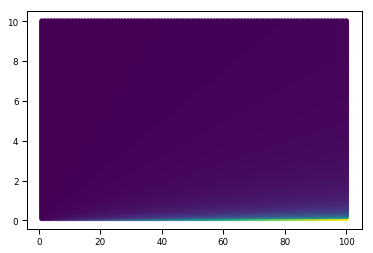

In [23]:
#create delta_ml and delta_theta graph
#delta_ml = error on lens mass; delta_theta = astrometric position

def color_code(lists):
    color_list = list()
    for i in range(len(lists[0])):
        point = (4 * 6.67408 * math.pow(10, -11) * lists[0][i]) / (math.pow(2.99 * math.pow(10, 8), 2) * lists[1][i]) #* distance to the lens
        color_list.append(point)
        
    return color_list
    
theta_list = list()
ml_list = list()
for i in range(100):
    for j in range(100):
        ml_list.append((i + 1)/10)
        theta_list.append(j + 1)
    
plot = plt.scatter(theta_list, ml_list, c = color_code([theta_list, ml_list]), cmap = 'viridis')

    #(4 * 6.67408 * math.pow(10, -11) * delta_ml) / (math.pow(2.99 * math.pow(10, 8), 2)) #* distance to lens